In [1]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import subprocess as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy

## Config

In [2]:
SEARCH_BS = False
# SEARCH_BS = True
SEARCH_LR = False
# SEARCH_LR = True

In [3]:
DEBUG = False
# DEBUG = True
TRAIN_ONE_SAMPLE = False
# TRAIN_ONE_SAMPLE = True

# Resize images
resize_img = 1300
if DEBUG:
    resize_img = 100
resize_img = int(32*int(resize_img/32))

# Batch size
BS_train = 4
if SEARCH_LR:
    BS_train = int(BS_train / 4)
    if BS_train == 0:
        BS_train = 1
if DEBUG:
    BS_train = 512
BS_val = BS_train * 4

# Train
EPOCHS = 400
if DEBUG:
    EPOCHS = 3
LR = 1e-2

# Save best model
NOTEBOOK_NAME = '10_Resnet50_albumentations'

# Dataset split
VALID_SPLIT = 0.2

# Model
number_of_classes = 2 # 2 classes
number_of_channels = 3
encoder_name = 'resnet50'
encoder_weights = 'imagenet'
activation = None
name_best_model = f'{NOTEBOOK_NAME}_best_model.pth'
name_early_stopping_model = f'{NOTEBOOK_NAME}_early_stopping.pth'
name_final_model = f'{NOTEBOOK_NAME}_final_model.pth'
path_to_save_models = path = Path("../models/")
path_best_model = path_to_save_models / name_best_model
path_early_stopping_model = path_to_save_models / name_early_stopping_model
path_final_model = path_to_save_models / name_final_model

# Learning rate decay
LE_DECAY_FACTOR = 0.1
LE_DECAY_PATIENCE = 10

# Early stopping
EARLY_STOPPING = False
EARLY_STOPPING_PATIENCE = 30

# Epochs when model can be saved
MIN_SAVE_EPOCHS = 10

# Data augmentation
AUGMENTATION = True
# AUGMENTATION = False

## Dataframe

In [4]:
path = Path("../")
data_path = path / "data"
train_images_path = data_path / "train_images"

In [5]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## Dice coefficient loss

In [6]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Data augmentation

In [7]:
transforms = {
    'train': 
        A.Compose(
            [
                A.Resize(resize_img, resize_img),
                A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                A.ToFloat(),
                ToTensorV2(),
            ]
        ),
    'val': 
        A.Compose(
            [
                A.Resize(resize_img, resize_img), 
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
                A.ToFloat(),
                ToTensorV2()
            ]
        ),
}

## Dataset and Dataloader

In [8]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [9]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4, transform=None):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    img_path = str(self.dataframe.iloc[ix]['path']) # Get image path from column 'path' in dataframe
    img_cv = cv2.imread(img_path) # Load image
    # img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)  # Convert to RGB

    rle = self.dataframe.iloc[ix]['rle']  # Get mask
    mask_cv = rle2mask(rle, img_cv.shape)
    mask_oh = np.eye(2)[mask_cv.astype(int)].astype(np.float32)  # One-hot encoding

    if self.transform:
      transformed = self.transform(image=img_cv, mask=mask_oh)
      img_tensor = transformed["image"]
      mask_tensor = transformed["mask"]
      if type(mask_tensor) == torch.Tensor:
        mask_tensor = mask_tensor.permute(2,0,1)
      else:
        mask_tensor = np.moveaxis(mask_tensor, 2, 0)
    else:
      img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation) # Resize image
      img_cv_res_norm = img_cv_res / 255.0  # Normalize image
      img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1) # Convert to tensor

      mask_cv_res = cv2.resize(mask_oh, dsize=(self.dim, self.dim), interpolation=self.interpolation) # Resize mask
      mask_tensor = torch.from_numpy(mask_cv_res).float().permute(2, 0, 1)  # Convert to tensor

    return img_tensor, mask_tensor
    

In [10]:
train_split, val_split = train_test_split(train_df, test_size=VALID_SPLIT, shuffle=True, random_state=42, stratify=train_df['organ'])
print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(train_split)} imágenes de entrenamiento y {len(val_split)} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 280 imágenes de entrenamiento y 71 imágenes de validación


In [11]:
if not TRAIN_ONE_SAMPLE:
    if AUGMENTATION:
        dataset = {
            'train': Dataset(train_split, n_classes=2, dim=resize_img, transform=transforms['train']),
            'val': Dataset(val_split, n_classes=2, dim=resize_img, transform=transforms['val']),
        }
    else:
        dataset = {
            'train': Dataset(train_split, n_classes=2, dim=resize_img),
            'val': Dataset(val_split, n_classes=2, dim=resize_img),
        }
else:
    if AUGMENTATION:
        dataset = {
            'train': Dataset(train_df[:1], n_classes=2, dim=resize_img, transform=transforms['train']),
            'val': Dataset(train_df[-1:], n_classes=2, dim=resize_img, transform=transforms['val']),
        }
    else:
        dataset = {
            'train': Dataset(train_df[:1], n_classes=2, dim=resize_img),
            'val': Dataset(train_df[-1:], n_classes=2, dim=resize_img),
        }

image type: <class 'numpy.ndarray'>, image shape: (1280, 1280, 3), image dtype: float32
mask type: <class 'numpy.ndarray'>, mask shape: (1280, 1280, 2), mask dtype: float32


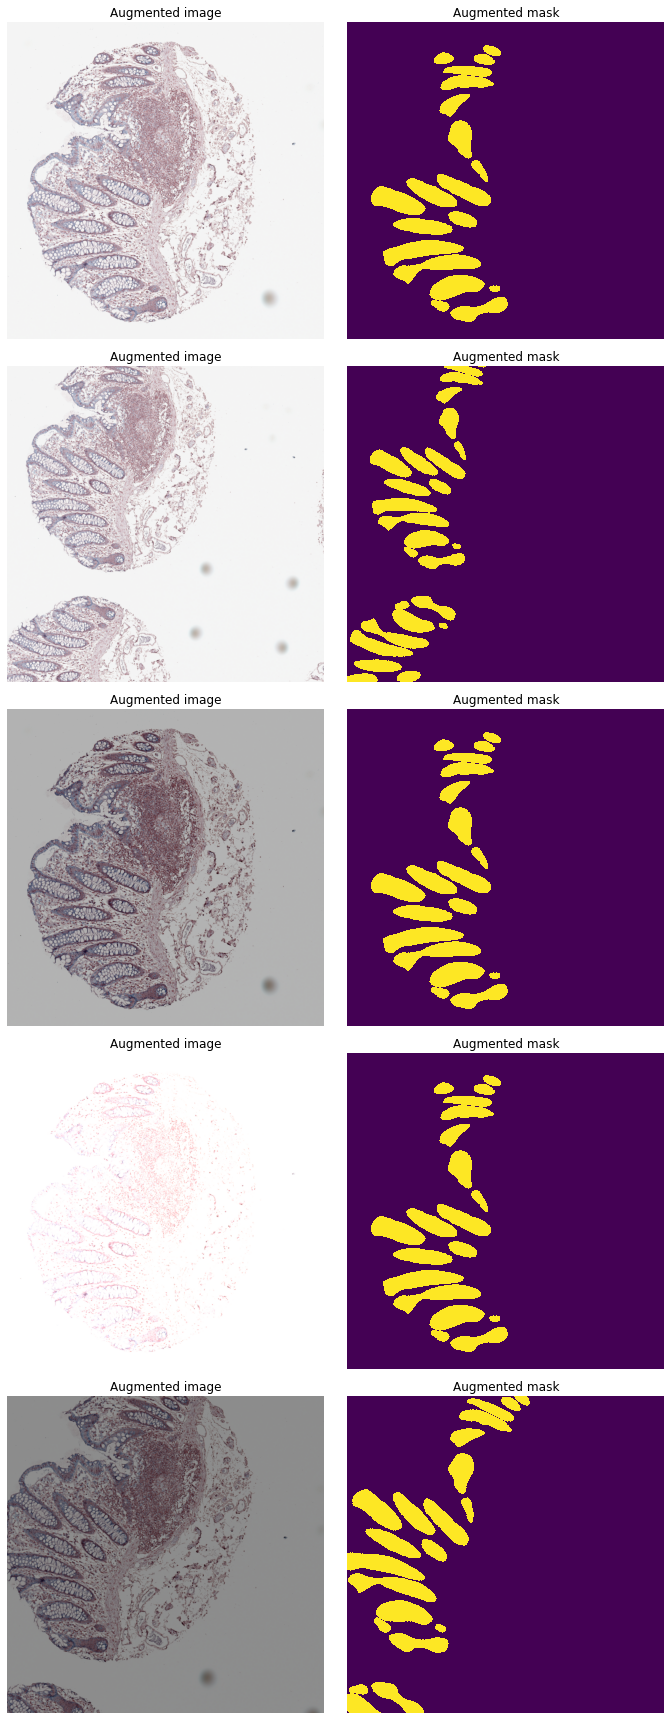

In [12]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    if dataset.transform:
        dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    else:
        samples = 1
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    if samples == 1:
        ax = np.expand_dims(ax, axis=0)
    for i in range(samples):
        image, mask = dataset[idx]
        if dataset.transform:
            mask = np.moveaxis(mask, 0, 2)
        if i==0:
            print(f"image type: {type(image)}, image shape: {image.shape}, image dtype: {image.dtype}")
            print(f"mask type: {type(mask)}, mask shape: {mask.shape}, mask dtype: {mask.dtype}")
        if dataset.transform:
            ax[i, 0].imshow(image)
            ax[i, 1].imshow(np.argmax(mask, axis=2), interpolation="nearest")
            ax[i, 0].set_title("Augmented image")
            ax[i, 1].set_title("Augmented mask")
            ax[i, 0].set_axis_off()
            ax[i, 1].set_axis_off()
        else:
            ax[i, 0].imshow(image.permute(1, 2, 0).numpy())
            ax[i, 1].imshow(np.argmax(mask, axis=0), interpolation="nearest")
            ax[i, 0].set_title("Augmented image")
            ax[i, 1].set_title("Augmented mask")
            ax[i, 0].set_axis_off()
            ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_augmentations(dataset['train'], idx=0)

In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

## Model initialization

In [14]:
def model_init():
    model = smp.Unet(encoder_name, encoder_weights=encoder_weights, in_channels=number_of_channels, classes=number_of_classes, activation=activation)
    return model

## Batch size finder

In [15]:
if SEARCH_BS:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() >= 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        else:
            model.cuda()
    else:
        print("Using CPU")

In [16]:
if SEARCH_BS:
    LR = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [17]:
if SEARCH_BS:
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        for (imgs, masks) in dataloader:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [18]:
if SEARCH_BS:
    def list_of_posible_batch_sizes(dataset):
        batch_sizes = []
        batch_size = 1
        while batch_size < 2*len(dataset):
            batch_sizes.append(batch_size)
            batch_size *= 2
        batch_sizes.sort(reverse=True)
        return batch_sizes

    BSs = list_of_posible_batch_sizes(dataset['train'])
    print(BSs)

In [19]:
if SEARCH_BS:
    for batchsize_train in BSs:
        print(f"batch size: {batchsize_train}")
        train_dl = torch.utils.data.DataLoader(dataset['train'], batch_size=batchsize_train, shuffle=True, pin_memory=True)
        epochs = 3
        out_of_memory = False
        for t in range(epochs):
            print(f"\tTrain epoch {t} of {epochs}")
            try:
                train_loop(train_dl, model, optimizer, optimizer)
            except Exception as e:
                if "CUDA out of memory" in str(e):
                    position = str(e).index('CUDA out of memory')
                    print(f"\t{str(e)[position:]}")
                    out_of_memory = True
                    break
                else:
                    out_of_memory = False
                break
        if out_of_memory == False:
            break
        print()
    print(f"Done!, bacth size is {batchsize_train}")

In [20]:
if SEARCH_BS:
    BS_train = batchsize_train
    BS_val = BS_train * 4
    print(f"For {resize_img}x{resize_img} images size, we use batch size of {BS_train} for train and batch size of {BS_val} for validation")

## Search LR

In [21]:
if SEARCH_LR:
    def lr_finder(model, train_dl, loss_fn, device, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
        num = len(train_dl)-1 # Numero de lrs que vamos a probar
        q = (lr_end/lr_init)**(1/num) # Incremento de lr
        lr = lr_init
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss = 0
        best_loss = 0.
        avg_loss = 0.
        smoothed_avg_losses = []
        lrs = []
        for batch, (imgs, masks) in enumerate(train_dl):
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Update optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
            smoothed_loss = avg_loss / (1 - beta**(batch+1))
            if increment is not None:
                # Se para si el loss se dispara
                window = 10
                if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                    return lrs, smoothed_avg_losses
            
            # Se guarda la menor pérdida
            if avg_loss < best_loss or batch==0:
                best_loss = smoothed_loss
            
            # Se guardan los datos
            smoothed_avg_losses.append(smoothed_loss)
            lrs.append(lr)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update lr
            lr *= q

        return lrs, smoothed_avg_losses

In [22]:
if SEARCH_LR:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    [lrss, smoothed_avg_losses] = lr_finder(model, train_dl=dataloader['train'], loss_fn = criterion, device=device)

    plt.plot(lrss, smoothed_avg_losses)
    plt.xlabel("lr")
    plt.ylabel("loss")
    plt.xscale("log")
    plt.grid()
    plt.show()

In [23]:
if SEARCH_LR:
    LR = 1e-2

## Train all images

In [24]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    train_loss, train_dice = [], []
    model.train()
    for imgs, masks in bar:
        # X and y to device
        imgs, masks = imgs.to(device), masks.to(device)
        # Compute prediction and loss
        pred_mask = model(imgs)
        loss = loss_fn(pred_mask, masks)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update train loss and dice
        dice = dice_coeff(pred_mask, masks)
        train_loss.append(loss.item())
        train_dice.append(dice)
        # Update progress bar
        bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
    hist['loss'].append(np.mean(train_loss))
    hist['dice'].append(np.mean(train_dice))
    return hist

def valid_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    val_loss, val_dice = [], []
    model.eval()
    with torch.no_grad():
        # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
        for imgs, masks in bar:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)
            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            # Update test loss and dice
            dice = dice_coeff(pred_mask, masks)
            val_loss.append(loss.item())
            val_dice.append(dice)
            # Update progress bar
            bar.set_description(f"\t\tval_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
    hist['val_loss'].append(np.mean(val_loss))
    hist['val_dice'].append(np.mean(val_dice))
    return hist

def fit(model, dataloader, device, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_dice = 0.
    early_stop_counter = 0
    schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=LE_DECAY_FACTOR, patience=LE_DECAY_PATIENCE, verbose=True)
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'val_loss': [], 'val_dice': []}
    for epoch in range(epochs):
        # Train
        bar = tqdm(dataloader['train'])
        hist = train_loop(dataloader, model, criterion, optimizer, bar, hist, device)

        # Validation
        bar = tqdm(dataloader['val'])
        hist = valid_loop(dataloader, model, criterion, optimizer, bar, hist, device)
        
        # Print epoch results
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")

        # Save model if best dice
        if hist['val_dice'][-1] > best_dice and epoch >= MIN_SAVE_EPOCHS:
            best_dice = hist['val_dice'][-1]
            torch.save(model, path_best_model)
            print(f"New best dice: {best_dice:.5f}, model saved to {path_best_model}")
        
        # Update scheduler
        schedulerOnPlateau.step(hist['val_loss'][-1])

        # Early stopping
        if hist['val_dice'][-1] < best_dice:
            early_stop_counter += 1
            if early_stop_counter == EARLY_STOPPING_PATIENCE+1:
                torch.save(model, path_early_stopping_model)
                print(f"Early stopping at epoch {epoch+1}")
                print(f"Early stopping dice: {hist['val_dice'][-1]}, model saved to {path_early_stopping_model}")
                if EARLY_STOPPING:
                    break
        else:
            early_stop_counter = 0
        
    # Save final model
    torch.save(model, path_final_model)
    print(f"Final model dice: {hist['val_dice'][-1]}, saved to {path_final_model}")
    
    return hist

In [25]:
if not SEARCH_BS and not SEARCH_LR:
    model = model_init()
    hist = fit(model, dataloader, device, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		val_loss 0.32665 val_dice 4.58555: 100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


Epoch 001/400 loss 0.31357 dice 7.46642 val_loss 0.32665 val_dice 4.58555


		val_loss 0.40010 val_dice 2.34933: 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


Epoch 002/400 loss 0.29222 dice 5.14605 val_loss 0.40010 val_dice 2.34933


		val_loss 0.32445 val_dice 3.76520: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 003/400 loss 0.27867 dice 5.71432 val_loss 0.32445 val_dice 3.76520


		val_loss 0.29060 val_dice 6.04224: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 004/400 loss 0.27072 dice 5.82424 val_loss 0.29060 val_dice 6.04224


		val_loss 0.32682 val_dice 2.85479: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 005/400 loss 0.26409 dice 6.29583 val_loss 0.32682 val_dice 2.85479


		val_loss 0.28373 val_dice 7.25024: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 006/400 loss 0.25713 dice 6.78764 val_loss 0.28373 val_dice 7.25024


		val_loss 0.27183 val_dice 5.46535: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 007/400 loss 0.25921 dice 6.19697 val_loss 0.27183 val_dice 5.46535


		val_loss 0.28948 val_dice 6.88672: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 008/400 loss 0.25948 dice 6.72490 val_loss 0.28948 val_dice 6.88672


		val_loss 0.28099 val_dice 4.86768: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 009/400 loss 0.27169 dice 6.13005 val_loss 0.28099 val_dice 4.86768


		val_loss 0.26908 val_dice 5.44636: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 010/400 loss 0.26596 dice 5.67587 val_loss 0.26908 val_dice 5.44636


		val_loss 0.27154 val_dice 5.93698: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 011/400 loss 0.25294 dice 7.11858 val_loss 0.27154 val_dice 5.93698
New best dice: 5.93698, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.32331 val_dice 4.61000: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 012/400 loss 0.25407 dice 6.84601 val_loss 0.32331 val_dice 4.61000


		val_loss 0.28643 val_dice 7.09345: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 013/400 loss 0.25475 dice 6.34945 val_loss 0.28643 val_dice 7.09345
New best dice: 7.09345, model saved to ../models/10_Resnet50_albumentations_best_model.pth
Epoch 00013: reducing learning rate of group 0 to 1.0000e-03.


		val_loss 0.26194 val_dice 6.66423: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 014/400 loss 0.24578 dice 6.61105 val_loss 0.26194 val_dice 6.66423


		val_loss 0.26570 val_dice 7.35367: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 015/400 loss 0.24840 dice 6.70131 val_loss 0.26570 val_dice 7.35367
New best dice: 7.35367, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.27327 val_dice 7.62622: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 016/400 loss 0.24284 dice 6.94802 val_loss 0.27327 val_dice 7.62622
New best dice: 7.62622, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.25941 val_dice 7.44064: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 017/400 loss 0.23883 dice 7.06719 val_loss 0.25941 val_dice 7.44064


		val_loss 0.25911 val_dice 7.69323: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 018/400 loss 0.23388 dice 7.26702 val_loss 0.25911 val_dice 7.69323
New best dice: 7.69323, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.25330 val_dice 7.47305: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 019/400 loss 0.23658 dice 7.34420 val_loss 0.25330 val_dice 7.47305


		val_loss 0.24820 val_dice 7.40689: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 020/400 loss 0.23630 dice 7.37932 val_loss 0.24820 val_dice 7.40689


		val_loss 0.25459 val_dice 7.88734: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 021/400 loss 0.23377 dice 7.36834 val_loss 0.25459 val_dice 7.88734
New best dice: 7.88734, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.24900 val_dice 7.47866: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 022/400 loss 0.23892 dice 7.43610 val_loss 0.24900 val_dice 7.47866


		val_loss 0.25530 val_dice 6.95165: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 023/400 loss 0.23300 dice 7.61523 val_loss 0.25530 val_dice 6.95165


		val_loss 0.25556 val_dice 7.64422: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 024/400 loss 0.23554 dice 7.52829 val_loss 0.25556 val_dice 7.64422
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.


		val_loss 0.24387 val_dice 7.32093: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 025/400 loss 0.22982 dice 7.62547 val_loss 0.24387 val_dice 7.32093


		val_loss 0.24271 val_dice 7.25318: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 026/400 loss 0.22787 dice 7.61065 val_loss 0.24271 val_dice 7.25318


		val_loss 0.24495 val_dice 7.18221: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 027/400 loss 0.23199 dice 7.63519 val_loss 0.24495 val_dice 7.18221


		val_loss 0.23927 val_dice 7.54210: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 028/400 loss 0.22253 dice 7.70644 val_loss 0.23927 val_dice 7.54210


		val_loss 0.24080 val_dice 7.63067: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 029/400 loss 0.22914 dice 7.69010 val_loss 0.24080 val_dice 7.63067


		val_loss 0.24172 val_dice 7.82988: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 030/400 loss 0.22746 dice 7.67655 val_loss 0.24172 val_dice 7.82988


		val_loss 0.23847 val_dice 7.58373: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 031/400 loss 0.22059 dice 7.79796 val_loss 0.23847 val_dice 7.58373


		val_loss 0.24045 val_dice 7.69347: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 032/400 loss 0.22548 dice 7.80473 val_loss 0.24045 val_dice 7.69347


		val_loss 0.25330 val_dice 7.52801: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 033/400 loss 0.22189 dice 7.80320 val_loss 0.25330 val_dice 7.52801


		val_loss 0.23736 val_dice 7.44473: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 034/400 loss 0.22824 dice 7.81038 val_loss 0.23736 val_dice 7.44473


		val_loss 0.24777 val_dice 7.12931: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 035/400 loss 0.22281 dice 7.81524 val_loss 0.24777 val_dice 7.12931
Epoch 00035: reducing learning rate of group 0 to 1.0000e-05.


		val_loss 0.23704 val_dice 7.19166: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 036/400 loss 0.21897 dice 7.87634 val_loss 0.23704 val_dice 7.19166


		val_loss 0.23653 val_dice 7.48583: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 037/400 loss 0.21987 dice 7.87336 val_loss 0.23653 val_dice 7.48583


		val_loss 0.23552 val_dice 7.31822: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 038/400 loss 0.22501 dice 7.84284 val_loss 0.23552 val_dice 7.31822


		val_loss 0.23216 val_dice 7.56839: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 039/400 loss 0.22503 dice 7.85962 val_loss 0.23216 val_dice 7.56839


		val_loss 0.23776 val_dice 7.37299: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 040/400 loss 0.22604 dice 7.82787 val_loss 0.23776 val_dice 7.37299


		val_loss 0.24221 val_dice 7.31787: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 041/400 loss 0.22220 dice 7.85092 val_loss 0.24221 val_dice 7.31787


		val_loss 0.24128 val_dice 7.69341: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 042/400 loss 0.22209 dice 7.87485 val_loss 0.24128 val_dice 7.69341


		val_loss 0.23874 val_dice 7.41006: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 043/400 loss 0.22564 dice 7.84234 val_loss 0.23874 val_dice 7.41006


		val_loss 0.24754 val_dice 8.00885: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 044/400 loss 0.22379 dice 7.85842 val_loss 0.24754 val_dice 8.00885
New best dice: 8.00885, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.23742 val_dice 7.70888: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 045/400 loss 0.22832 dice 7.81090 val_loss 0.23742 val_dice 7.70888


		val_loss 0.23852 val_dice 7.43798: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 046/400 loss 0.22652 dice 7.85598 val_loss 0.23852 val_dice 7.43798
Epoch 00046: reducing learning rate of group 0 to 1.0000e-06.


		val_loss 0.23819 val_dice 7.25406: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 047/400 loss 0.22596 dice 7.82874 val_loss 0.23819 val_dice 7.25406


		val_loss 0.23542 val_dice 7.53241: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 048/400 loss 0.22383 dice 7.86291 val_loss 0.23542 val_dice 7.53241


		val_loss 0.24104 val_dice 7.58712: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 049/400 loss 0.22402 dice 7.85745 val_loss 0.24104 val_dice 7.58712


		val_loss 0.24485 val_dice 7.58475: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 050/400 loss 0.22395 dice 7.84787 val_loss 0.24485 val_dice 7.58475


		val_loss 0.24088 val_dice 7.76483: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 051/400 loss 0.23122 dice 7.84374 val_loss 0.24088 val_dice 7.76483


		val_loss 0.24189 val_dice 7.54223: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 052/400 loss 0.21651 dice 7.89220 val_loss 0.24189 val_dice 7.54223


		val_loss 0.23837 val_dice 7.31369: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 053/400 loss 0.22629 dice 7.84079 val_loss 0.23837 val_dice 7.31369


		val_loss 0.23899 val_dice 7.90058: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 054/400 loss 0.22469 dice 7.85868 val_loss 0.23899 val_dice 7.90058


		val_loss 0.23770 val_dice 7.47421: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 055/400 loss 0.22480 dice 7.84919 val_loss 0.23770 val_dice 7.47421


		val_loss 0.25024 val_dice 7.32604: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 056/400 loss 0.22458 dice 7.83641 val_loss 0.25024 val_dice 7.32604


		val_loss 0.24132 val_dice 7.35836: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 057/400 loss 0.22714 dice 7.82435 val_loss 0.24132 val_dice 7.35836
Epoch 00057: reducing learning rate of group 0 to 1.0000e-07.


		val_loss 0.23925 val_dice 7.29782: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 058/400 loss 0.22074 dice 7.86585 val_loss 0.23925 val_dice 7.29782


		val_loss 0.24334 val_dice 7.41241: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 059/400 loss 0.22404 dice 7.83437 val_loss 0.24334 val_dice 7.41241


		val_loss 0.23513 val_dice 7.63884: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 060/400 loss 0.22498 dice 7.85770 val_loss 0.23513 val_dice 7.63884


		val_loss 0.25005 val_dice 7.53971: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 061/400 loss 0.22555 dice 7.83096 val_loss 0.25005 val_dice 7.53971


		val_loss 0.23571 val_dice 7.67659: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 062/400 loss 0.22473 dice 7.83978 val_loss 0.23571 val_dice 7.67659


		val_loss 0.23942 val_dice 7.11380: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 063/400 loss 0.22355 dice 7.86343 val_loss 0.23942 val_dice 7.11380


		val_loss 0.23850 val_dice 7.31074: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 064/400 loss 0.22392 dice 7.84505 val_loss 0.23850 val_dice 7.31074


		val_loss 0.23684 val_dice 7.50008: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 065/400 loss 0.22453 dice 7.84239 val_loss 0.23684 val_dice 7.50008


		val_loss 0.24051 val_dice 7.27288: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 066/400 loss 0.21854 dice 7.87240 val_loss 0.24051 val_dice 7.27288


		val_loss 0.23482 val_dice 7.54795: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 067/400 loss 0.22258 dice 7.86638 val_loss 0.23482 val_dice 7.54795


		val_loss 0.24639 val_dice 7.79061: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 068/400 loss 0.22425 dice 7.85196 val_loss 0.24639 val_dice 7.79061
Epoch 00068: reducing learning rate of group 0 to 1.0000e-08.


		val_loss 0.23642 val_dice 7.40309: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 069/400 loss 0.21586 dice 7.87928 val_loss 0.23642 val_dice 7.40309


		val_loss 0.24056 val_dice 7.71209: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 070/400 loss 0.22213 dice 7.87310 val_loss 0.24056 val_dice 7.71209


		val_loss 0.23903 val_dice 7.61711: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 071/400 loss 0.22282 dice 7.85729 val_loss 0.23903 val_dice 7.61711


		val_loss 0.24168 val_dice 7.52794: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 072/400 loss 0.22714 dice 7.84142 val_loss 0.24168 val_dice 7.52794


		val_loss 0.23717 val_dice 7.44382: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 073/400 loss 0.22280 dice 7.86724 val_loss 0.23717 val_dice 7.44382


		val_loss 0.23925 val_dice 7.45970: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 074/400 loss 0.22788 dice 7.85051 val_loss 0.23925 val_dice 7.45970


		val_loss 0.24373 val_dice 7.76265: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 075/400 loss 0.22744 dice 7.82750 val_loss 0.24373 val_dice 7.76265
Early stopping at epoch 75
Early stopping dice: 7.762654113769531, model saved to ../models/10_Resnet50_albumentations_early_stopping.pth


		val_loss 0.23485 val_dice 7.61189: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 076/400 loss 0.22090 dice 7.86320 val_loss 0.23485 val_dice 7.61189


		val_loss 0.24121 val_dice 7.31501: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 077/400 loss 0.22488 dice 7.85668 val_loss 0.24121 val_dice 7.31501


		val_loss 0.24169 val_dice 7.29823: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 078/400 loss 0.22892 dice 7.85309 val_loss 0.24169 val_dice 7.29823


		val_loss 0.23941 val_dice 7.50480: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 079/400 loss 0.23082 dice 7.81441 val_loss 0.23941 val_dice 7.50480


		val_loss 0.23723 val_dice 7.57724: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 080/400 loss 0.22807 dice 7.82749 val_loss 0.23723 val_dice 7.57724


		val_loss 0.23989 val_dice 7.91705: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 081/400 loss 0.22014 dice 7.87879 val_loss 0.23989 val_dice 7.91705


		val_loss 0.24210 val_dice 7.51029: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 082/400 loss 0.22531 dice 7.86060 val_loss 0.24210 val_dice 7.51029


		val_loss 0.24075 val_dice 7.46547: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 083/400 loss 0.22218 dice 7.85756 val_loss 0.24075 val_dice 7.46547


		val_loss 0.24216 val_dice 7.76972: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 084/400 loss 0.22840 dice 7.83487 val_loss 0.24216 val_dice 7.76972


		val_loss 0.24057 val_dice 7.58466: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 085/400 loss 0.22054 dice 7.86892 val_loss 0.24057 val_dice 7.58466


		val_loss 0.23839 val_dice 7.82353: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 086/400 loss 0.22188 dice 7.87163 val_loss 0.23839 val_dice 7.82353


		val_loss 0.25012 val_dice 7.65210: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


Epoch 087/400 loss 0.23044 dice 7.81769 val_loss 0.25012 val_dice 7.65210


		val_loss 0.24298 val_dice 7.55078: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 088/400 loss 0.22550 dice 7.83986 val_loss 0.24298 val_dice 7.55078


		val_loss 0.23667 val_dice 7.36726: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 089/400 loss 0.21971 dice 7.87809 val_loss 0.23667 val_dice 7.36726


		val_loss 0.24258 val_dice 7.48506: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 090/400 loss 0.23034 dice 7.81338 val_loss 0.24258 val_dice 7.48506


		val_loss 0.24532 val_dice 7.98478: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 091/400 loss 0.22665 dice 7.84349 val_loss 0.24532 val_dice 7.98478


		val_loss 0.23603 val_dice 7.28948: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 092/400 loss 0.22309 dice 7.86264 val_loss 0.23603 val_dice 7.28948


		val_loss 0.24317 val_dice 7.65815: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 093/400 loss 0.22646 dice 7.82356 val_loss 0.24317 val_dice 7.65815


		val_loss 0.24345 val_dice 7.71193: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 094/400 loss 0.22279 dice 7.85752 val_loss 0.24345 val_dice 7.71193


		val_loss 0.23699 val_dice 7.41521: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 095/400 loss 0.22619 dice 7.83928 val_loss 0.23699 val_dice 7.41521


		val_loss 0.23445 val_dice 7.56036: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 096/400 loss 0.22815 dice 7.83929 val_loss 0.23445 val_dice 7.56036


		val_loss 0.23885 val_dice 7.49354: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 097/400 loss 0.22394 dice 7.84983 val_loss 0.23885 val_dice 7.49354


		val_loss 0.23458 val_dice 7.61669: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 098/400 loss 0.22335 dice 7.87194 val_loss 0.23458 val_dice 7.61669


		val_loss 0.23516 val_dice 7.60845: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 099/400 loss 0.22638 dice 7.83312 val_loss 0.23516 val_dice 7.60845


		val_loss 0.24201 val_dice 7.48221: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 100/400 loss 0.22784 dice 7.83989 val_loss 0.24201 val_dice 7.48221


		val_loss 0.23588 val_dice 7.49288: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 101/400 loss 0.22415 dice 7.83678 val_loss 0.23588 val_dice 7.49288


		val_loss 0.23674 val_dice 7.61336: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 102/400 loss 0.23390 dice 7.80784 val_loss 0.23674 val_dice 7.61336


		val_loss 0.23635 val_dice 7.49025: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 103/400 loss 0.22059 dice 7.86545 val_loss 0.23635 val_dice 7.49025


		val_loss 0.23979 val_dice 7.27714: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 104/400 loss 0.22711 dice 7.85002 val_loss 0.23979 val_dice 7.27714


		val_loss 0.24508 val_dice 8.03273: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 105/400 loss 0.22232 dice 7.86410 val_loss 0.24508 val_dice 8.03273
New best dice: 8.03273, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.23524 val_dice 7.56161: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 106/400 loss 0.23057 dice 7.81529 val_loss 0.23524 val_dice 7.56161


		val_loss 0.23997 val_dice 7.33375: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 107/400 loss 0.22334 dice 7.84567 val_loss 0.23997 val_dice 7.33375


		val_loss 0.23791 val_dice 7.47044: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 108/400 loss 0.22087 dice 7.87934 val_loss 0.23791 val_dice 7.47044


		val_loss 0.24374 val_dice 7.12668: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 109/400 loss 0.22333 dice 7.85698 val_loss 0.24374 val_dice 7.12668


		val_loss 0.23686 val_dice 7.48989: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 110/400 loss 0.21830 dice 7.90164 val_loss 0.23686 val_dice 7.48989


		val_loss 0.23446 val_dice 7.67715: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 111/400 loss 0.22671 dice 7.85897 val_loss 0.23446 val_dice 7.67715


		val_loss 0.24123 val_dice 7.88377: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 112/400 loss 0.22148 dice 7.85011 val_loss 0.24123 val_dice 7.88377


		val_loss 0.24103 val_dice 7.60158: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 113/400 loss 0.22395 dice 7.83145 val_loss 0.24103 val_dice 7.60158


		val_loss 0.24337 val_dice 7.12549: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 114/400 loss 0.22727 dice 7.81100 val_loss 0.24337 val_dice 7.12549


		val_loss 0.23695 val_dice 7.48258: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 115/400 loss 0.22287 dice 7.87294 val_loss 0.23695 val_dice 7.48258


		val_loss 0.23755 val_dice 7.40635: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 116/400 loss 0.22302 dice 7.85956 val_loss 0.23755 val_dice 7.40635


		val_loss 0.23728 val_dice 7.27149: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 117/400 loss 0.22210 dice 7.84021 val_loss 0.23728 val_dice 7.27149


		val_loss 0.25543 val_dice 7.32786: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 118/400 loss 0.22917 dice 7.82514 val_loss 0.25543 val_dice 7.32786


		val_loss 0.23553 val_dice 7.41484: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 119/400 loss 0.22901 dice 7.81028 val_loss 0.23553 val_dice 7.41484


		val_loss 0.23766 val_dice 7.44913: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 120/400 loss 0.23039 dice 7.81727 val_loss 0.23766 val_dice 7.44913


		val_loss 0.23505 val_dice 7.44589: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 121/400 loss 0.22245 dice 7.87157 val_loss 0.23505 val_dice 7.44589


		val_loss 0.23882 val_dice 7.36215: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 122/400 loss 0.22223 dice 7.86005 val_loss 0.23882 val_dice 7.36215


		val_loss 0.23667 val_dice 7.51085: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 123/400 loss 0.22293 dice 7.86935 val_loss 0.23667 val_dice 7.51085


		val_loss 0.23587 val_dice 7.54590: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 124/400 loss 0.22283 dice 7.87245 val_loss 0.23587 val_dice 7.54590


		val_loss 0.24384 val_dice 7.55255: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 125/400 loss 0.22851 dice 7.81768 val_loss 0.24384 val_dice 7.55255


		val_loss 0.24796 val_dice 7.74757: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 126/400 loss 0.22166 dice 7.86639 val_loss 0.24796 val_dice 7.74757


		val_loss 0.23528 val_dice 7.58114: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 127/400 loss 0.22150 dice 7.87846 val_loss 0.23528 val_dice 7.58114


		val_loss 0.24451 val_dice 7.84192: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 128/400 loss 0.22196 dice 7.83318 val_loss 0.24451 val_dice 7.84192


		val_loss 0.25402 val_dice 7.77122: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 129/400 loss 0.22705 dice 7.84495 val_loss 0.25402 val_dice 7.77122


		val_loss 0.23805 val_dice 7.43950: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 130/400 loss 0.22318 dice 7.85906 val_loss 0.23805 val_dice 7.43950


		val_loss 0.23780 val_dice 7.27058: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 131/400 loss 0.22501 dice 7.84870 val_loss 0.23780 val_dice 7.27058


		val_loss 0.24064 val_dice 7.17903: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 132/400 loss 0.22349 dice 7.87222 val_loss 0.24064 val_dice 7.17903


		val_loss 0.23773 val_dice 7.32717: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 133/400 loss 0.22941 dice 7.81559 val_loss 0.23773 val_dice 7.32717


		val_loss 0.24108 val_dice 7.48524: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 134/400 loss 0.22332 dice 7.85618 val_loss 0.24108 val_dice 7.48524


		val_loss 0.23695 val_dice 7.59485: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 135/400 loss 0.22438 dice 7.84847 val_loss 0.23695 val_dice 7.59485


		val_loss 0.24062 val_dice 7.34761: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 136/400 loss 0.23193 dice 7.82034 val_loss 0.24062 val_dice 7.34761
Early stopping at epoch 136
Early stopping dice: 7.347609233856201, model saved to ../models/10_Resnet50_albumentations_early_stopping.pth


		val_loss 0.23824 val_dice 7.39596: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 137/400 loss 0.22671 dice 7.83313 val_loss 0.23824 val_dice 7.39596


		val_loss 0.23800 val_dice 7.70562: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 138/400 loss 0.22136 dice 7.88431 val_loss 0.23800 val_dice 7.70562


		val_loss 0.24092 val_dice 7.04062: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 139/400 loss 0.22849 dice 7.82470 val_loss 0.24092 val_dice 7.04062


		val_loss 0.23764 val_dice 7.67809: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 140/400 loss 0.22237 dice 7.86102 val_loss 0.23764 val_dice 7.67809


		val_loss 0.23787 val_dice 7.67681: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 141/400 loss 0.22398 dice 7.86299 val_loss 0.23787 val_dice 7.67681


		val_loss 0.23603 val_dice 7.69898: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 142/400 loss 0.22281 dice 7.85411 val_loss 0.23603 val_dice 7.69898


		val_loss 0.24243 val_dice 7.59074: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 143/400 loss 0.22285 dice 7.85523 val_loss 0.24243 val_dice 7.59074


		val_loss 0.23839 val_dice 8.08455: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 144/400 loss 0.22663 dice 7.83842 val_loss 0.23839 val_dice 8.08455
New best dice: 8.08455, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.23554 val_dice 7.48012: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 145/400 loss 0.22966 dice 7.81883 val_loss 0.23554 val_dice 7.48012


		val_loss 0.23859 val_dice 7.66366: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 146/400 loss 0.21861 dice 7.87753 val_loss 0.23859 val_dice 7.66366


		val_loss 0.24409 val_dice 7.67713: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 147/400 loss 0.21930 dice 7.86811 val_loss 0.24409 val_dice 7.67713


		val_loss 0.23458 val_dice 7.60364: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 148/400 loss 0.22215 dice 7.87483 val_loss 0.23458 val_dice 7.60364


		val_loss 0.24238 val_dice 7.46138: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 149/400 loss 0.22732 dice 7.82768 val_loss 0.24238 val_dice 7.46138


		val_loss 0.23606 val_dice 7.52344: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 150/400 loss 0.22867 dice 7.81278 val_loss 0.23606 val_dice 7.52344


		val_loss 0.23973 val_dice 7.60238: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 151/400 loss 0.22459 dice 7.85379 val_loss 0.23973 val_dice 7.60238


		val_loss 0.24710 val_dice 7.33731: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 152/400 loss 0.22757 dice 7.84149 val_loss 0.24710 val_dice 7.33731


		val_loss 0.23671 val_dice 7.52866: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 153/400 loss 0.22302 dice 7.85377 val_loss 0.23671 val_dice 7.52866


		val_loss 0.23834 val_dice 7.45031: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 154/400 loss 0.21904 dice 7.87914 val_loss 0.23834 val_dice 7.45031


		val_loss 0.24099 val_dice 7.32620: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 155/400 loss 0.22422 dice 7.85569 val_loss 0.24099 val_dice 7.32620


		val_loss 0.24086 val_dice 7.67652: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 156/400 loss 0.22211 dice 7.85371 val_loss 0.24086 val_dice 7.67652


		val_loss 0.24487 val_dice 8.02094: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 157/400 loss 0.21882 dice 7.91219 val_loss 0.24487 val_dice 8.02094


		val_loss 0.23730 val_dice 7.34950: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 158/400 loss 0.22410 dice 7.85827 val_loss 0.23730 val_dice 7.34950


		val_loss 0.24216 val_dice 7.60801: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 159/400 loss 0.22470 dice 7.82908 val_loss 0.24216 val_dice 7.60801


		val_loss 0.23728 val_dice 7.45487: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 160/400 loss 0.22762 dice 7.81666 val_loss 0.23728 val_dice 7.45487


		val_loss 0.23913 val_dice 7.31540: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 161/400 loss 0.22263 dice 7.85637 val_loss 0.23913 val_dice 7.31540


		val_loss 0.23511 val_dice 7.44554: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 162/400 loss 0.22254 dice 7.86162 val_loss 0.23511 val_dice 7.44554


		val_loss 0.23614 val_dice 7.45323: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 163/400 loss 0.21960 dice 7.88443 val_loss 0.23614 val_dice 7.45323


		val_loss 0.24450 val_dice 7.14208: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 164/400 loss 0.22854 dice 7.82064 val_loss 0.24450 val_dice 7.14208


		val_loss 0.23596 val_dice 7.64009: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 165/400 loss 0.22611 dice 7.85679 val_loss 0.23596 val_dice 7.64009


		val_loss 0.23530 val_dice 7.30824: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 166/400 loss 0.22566 dice 7.85014 val_loss 0.23530 val_dice 7.30824


		val_loss 0.24129 val_dice 7.57672: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 167/400 loss 0.22337 dice 7.85080 val_loss 0.24129 val_dice 7.57672


		val_loss 0.23575 val_dice 7.43614: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 168/400 loss 0.22912 dice 7.83475 val_loss 0.23575 val_dice 7.43614


		val_loss 0.24467 val_dice 7.58689: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 169/400 loss 0.22271 dice 7.85946 val_loss 0.24467 val_dice 7.58689


		val_loss 0.23869 val_dice 7.78057: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 170/400 loss 0.22785 dice 7.80763 val_loss 0.23869 val_dice 7.78057


		val_loss 0.23801 val_dice 7.56418: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 171/400 loss 0.22733 dice 7.81784 val_loss 0.23801 val_dice 7.56418


		val_loss 0.23765 val_dice 7.40688: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 172/400 loss 0.22878 dice 7.83655 val_loss 0.23765 val_dice 7.40688


		val_loss 0.23834 val_dice 7.40022: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 173/400 loss 0.23321 dice 7.81909 val_loss 0.23834 val_dice 7.40022


		val_loss 0.23526 val_dice 7.45190: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 174/400 loss 0.23060 dice 7.84507 val_loss 0.23526 val_dice 7.45190


		val_loss 0.24708 val_dice 7.50286: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 175/400 loss 0.22633 dice 7.86625 val_loss 0.24708 val_dice 7.50286
Early stopping at epoch 175
Early stopping dice: 7.502863883972168, model saved to ../models/10_Resnet50_albumentations_early_stopping.pth


		val_loss 0.23705 val_dice 7.28469: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 176/400 loss 0.22444 dice 7.85013 val_loss 0.23705 val_dice 7.28469


		val_loss 0.23823 val_dice 7.38368: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 177/400 loss 0.22407 dice 7.84601 val_loss 0.23823 val_dice 7.38368


		val_loss 0.23893 val_dice 7.55443: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 178/400 loss 0.22412 dice 7.86354 val_loss 0.23893 val_dice 7.55443


		val_loss 0.25072 val_dice 7.24263: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 179/400 loss 0.22247 dice 7.88423 val_loss 0.25072 val_dice 7.24263


		val_loss 0.24292 val_dice 8.15017: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 180/400 loss 0.22997 dice 7.83143 val_loss 0.24292 val_dice 8.15017
New best dice: 8.15017, model saved to ../models/10_Resnet50_albumentations_best_model.pth


		val_loss 0.24416 val_dice 7.44659: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 181/400 loss 0.22174 dice 7.88061 val_loss 0.24416 val_dice 7.44659


		val_loss 0.23903 val_dice 7.72168: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 182/400 loss 0.22534 dice 7.84946 val_loss 0.23903 val_dice 7.72168


		val_loss 0.24220 val_dice 7.94555: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 183/400 loss 0.22240 dice 7.87688 val_loss 0.24220 val_dice 7.94555


		val_loss 0.23405 val_dice 7.59594: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 184/400 loss 0.22374 dice 7.83683 val_loss 0.23405 val_dice 7.59594


		val_loss 0.24145 val_dice 7.60636: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 185/400 loss 0.22346 dice 7.85291 val_loss 0.24145 val_dice 7.60636


		val_loss 0.23720 val_dice 7.60224: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 186/400 loss 0.22330 dice 7.86887 val_loss 0.23720 val_dice 7.60224


		val_loss 0.25592 val_dice 7.83406: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 187/400 loss 0.22134 dice 7.84686 val_loss 0.25592 val_dice 7.83406


		val_loss 0.23681 val_dice 7.65726: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 188/400 loss 0.21966 dice 7.88078 val_loss 0.23681 val_dice 7.65726


		val_loss 0.24169 val_dice 7.06902: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 189/400 loss 0.22232 dice 7.88010 val_loss 0.24169 val_dice 7.06902


		val_loss 0.24095 val_dice 7.73139: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 190/400 loss 0.22940 dice 7.80998 val_loss 0.24095 val_dice 7.73139


		val_loss 0.23718 val_dice 7.76681: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 191/400 loss 0.22253 dice 7.86945 val_loss 0.23718 val_dice 7.76681


		val_loss 0.23959 val_dice 7.11992: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 192/400 loss 0.22278 dice 7.84082 val_loss 0.23959 val_dice 7.11992


		val_loss 0.23439 val_dice 7.28578: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 193/400 loss 0.22346 dice 7.87944 val_loss 0.23439 val_dice 7.28578


		val_loss 0.23406 val_dice 7.72528: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 194/400 loss 0.22236 dice 7.87480 val_loss 0.23406 val_dice 7.72528


		val_loss 0.23692 val_dice 7.42931: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 195/400 loss 0.22237 dice 7.84779 val_loss 0.23692 val_dice 7.42931


		val_loss 0.23755 val_dice 7.39991: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 196/400 loss 0.22645 dice 7.84857 val_loss 0.23755 val_dice 7.39991


		val_loss 0.24080 val_dice 7.91206: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 197/400 loss 0.22526 dice 7.84060 val_loss 0.24080 val_dice 7.91206


		val_loss 0.23746 val_dice 7.46510: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 198/400 loss 0.22338 dice 7.85607 val_loss 0.23746 val_dice 7.46510


		val_loss 0.24662 val_dice 7.57299: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 199/400 loss 0.22391 dice 7.85750 val_loss 0.24662 val_dice 7.57299


		val_loss 0.24011 val_dice 7.55346: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 200/400 loss 0.22966 dice 7.84164 val_loss 0.24011 val_dice 7.55346


		val_loss 0.23447 val_dice 7.79226: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 201/400 loss 0.22174 dice 7.86886 val_loss 0.23447 val_dice 7.79226


		val_loss 0.24119 val_dice 7.64263: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 202/400 loss 0.21791 dice 7.86885 val_loss 0.24119 val_dice 7.64263


		val_loss 0.23313 val_dice 7.65493: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 203/400 loss 0.22513 dice 7.84887 val_loss 0.23313 val_dice 7.65493


		val_loss 0.24068 val_dice 7.53265: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 204/400 loss 0.22288 dice 7.87663 val_loss 0.24068 val_dice 7.53265


		val_loss 0.23557 val_dice 7.78839: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


Epoch 205/400 loss 0.22220 dice 7.86785 val_loss 0.23557 val_dice 7.78839


		val_loss 0.23451 val_dice 7.57842: 100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


Epoch 206/400 loss 0.22807 dice 7.83891 val_loss 0.23451 val_dice 7.57842


		val_loss 0.24245 val_dice 7.35292: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


Epoch 207/400 loss 0.22398 dice 7.84531 val_loss 0.24245 val_dice 7.35292


		val_loss 0.24261 val_dice 7.60471: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 208/400 loss 0.22330 dice 7.86253 val_loss 0.24261 val_dice 7.60471


		val_loss 0.24613 val_dice 7.77378: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 209/400 loss 0.21904 dice 7.89339 val_loss 0.24613 val_dice 7.77378


		val_loss 0.23534 val_dice 7.43509: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 210/400 loss 0.22322 dice 7.84581 val_loss 0.23534 val_dice 7.43509


		val_loss 0.23344 val_dice 7.78892: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 211/400 loss 0.22862 dice 7.82113 val_loss 0.23344 val_dice 7.78892
Early stopping at epoch 211
Early stopping dice: 7.788918781280517, model saved to ../models/10_Resnet50_albumentations_early_stopping.pth


		val_loss 0.24021 val_dice 7.91417: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 212/400 loss 0.23570 dice 7.80116 val_loss 0.24021 val_dice 7.91417


		val_loss 0.23911 val_dice 7.26885: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 213/400 loss 0.22396 dice 7.85731 val_loss 0.23911 val_dice 7.26885


		val_loss 0.23694 val_dice 7.38956: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 214/400 loss 0.22394 dice 7.83885 val_loss 0.23694 val_dice 7.38956


		val_loss 0.24431 val_dice 7.34138: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 215/400 loss 0.22825 dice 7.84365 val_loss 0.24431 val_dice 7.34138


		val_loss 0.24650 val_dice 7.74416: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 216/400 loss 0.22495 dice 7.84774 val_loss 0.24650 val_dice 7.74416


		val_loss 0.23478 val_dice 7.62646: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 217/400 loss 0.22526 dice 7.81293 val_loss 0.23478 val_dice 7.62646


		val_loss 0.24188 val_dice 7.68211: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 218/400 loss 0.22317 dice 7.87934 val_loss 0.24188 val_dice 7.68211


		val_loss 0.23730 val_dice 7.50288: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 219/400 loss 0.22315 dice 7.86083 val_loss 0.23730 val_dice 7.50288


		val_loss 0.23465 val_dice 7.81181: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 220/400 loss 0.21833 dice 7.87366 val_loss 0.23465 val_dice 7.81181


		val_loss 0.23699 val_dice 7.59922: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 221/400 loss 0.22222 dice 7.85019 val_loss 0.23699 val_dice 7.59922


		val_loss 0.24064 val_dice 7.37847: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 222/400 loss 0.22012 dice 7.87957 val_loss 0.24064 val_dice 7.37847


		val_loss 0.24170 val_dice 7.29933: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 223/400 loss 0.22694 dice 7.84822 val_loss 0.24170 val_dice 7.29933


		val_loss 0.23600 val_dice 7.80414: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 224/400 loss 0.22286 dice 7.87189 val_loss 0.23600 val_dice 7.80414


		val_loss 0.24125 val_dice 7.98634: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 225/400 loss 0.22303 dice 7.85044 val_loss 0.24125 val_dice 7.98634


		val_loss 0.24238 val_dice 7.54621: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 226/400 loss 0.22424 dice 7.86777 val_loss 0.24238 val_dice 7.54621


		val_loss 0.25334 val_dice 7.02693: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 227/400 loss 0.22712 dice 7.82481 val_loss 0.25334 val_dice 7.02693


		val_loss 0.24164 val_dice 7.78480: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 228/400 loss 0.22789 dice 7.82821 val_loss 0.24164 val_dice 7.78480


		val_loss 0.24183 val_dice 7.25783: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 229/400 loss 0.22326 dice 7.84830 val_loss 0.24183 val_dice 7.25783


		val_loss 0.23970 val_dice 7.91915: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 230/400 loss 0.22040 dice 7.87123 val_loss 0.23970 val_dice 7.91915


		val_loss 0.25386 val_dice 7.53376: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 231/400 loss 0.22444 dice 7.85977 val_loss 0.25386 val_dice 7.53376


		val_loss 0.23625 val_dice 7.52511: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 232/400 loss 0.22470 dice 7.86989 val_loss 0.23625 val_dice 7.52511


		val_loss 0.23743 val_dice 7.37295: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 233/400 loss 0.22270 dice 7.88684 val_loss 0.23743 val_dice 7.37295


		val_loss 0.24009 val_dice 7.57012: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 234/400 loss 0.22382 dice 7.84800 val_loss 0.24009 val_dice 7.57012


		val_loss 0.23877 val_dice 7.60964: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 235/400 loss 0.22470 dice 7.87206 val_loss 0.23877 val_dice 7.60964


		val_loss 0.23607 val_dice 7.71190: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 236/400 loss 0.22542 dice 7.84891 val_loss 0.23607 val_dice 7.71190


		val_loss 0.24176 val_dice 7.60633: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 237/400 loss 0.22734 dice 7.83010 val_loss 0.24176 val_dice 7.60633


		val_loss 0.23692 val_dice 7.41812: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 238/400 loss 0.22830 dice 7.79662 val_loss 0.23692 val_dice 7.41812


		val_loss 0.23788 val_dice 7.83790: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 239/400 loss 0.22015 dice 7.84797 val_loss 0.23788 val_dice 7.83790


		val_loss 0.23934 val_dice 7.47750: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 240/400 loss 0.22666 dice 7.84527 val_loss 0.23934 val_dice 7.47750


		val_loss 0.23585 val_dice 7.42080: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 241/400 loss 0.22323 dice 7.86979 val_loss 0.23585 val_dice 7.42080


		val_loss 0.23927 val_dice 8.04408: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 242/400 loss 0.21951 dice 7.88665 val_loss 0.23927 val_dice 8.04408


		val_loss 0.23942 val_dice 7.47259: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 243/400 loss 0.22382 dice 7.84660 val_loss 0.23942 val_dice 7.47259


		val_loss 0.24030 val_dice 7.62713: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 244/400 loss 0.22818 dice 7.83069 val_loss 0.24030 val_dice 7.62713


		val_loss 0.24203 val_dice 7.34058: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 245/400 loss 0.23028 dice 7.83465 val_loss 0.24203 val_dice 7.34058


		val_loss 0.23606 val_dice 7.62352: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 246/400 loss 0.22546 dice 7.86381 val_loss 0.23606 val_dice 7.62352


		val_loss 0.23790 val_dice 7.70697: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 247/400 loss 0.22209 dice 7.85931 val_loss 0.23790 val_dice 7.70697


		val_loss 0.23736 val_dice 7.60530: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 248/400 loss 0.22942 dice 7.83179 val_loss 0.23736 val_dice 7.60530


		val_loss 0.23778 val_dice 7.80883: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 249/400 loss 0.22224 dice 7.88901 val_loss 0.23778 val_dice 7.80883


		val_loss 0.23688 val_dice 7.83506: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 250/400 loss 0.22912 dice 7.83789 val_loss 0.23688 val_dice 7.83506


		val_loss 0.23522 val_dice 7.57415: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 251/400 loss 0.22347 dice 7.86678 val_loss 0.23522 val_dice 7.57415


		val_loss 0.24415 val_dice 7.65391: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 252/400 loss 0.21969 dice 7.86667 val_loss 0.24415 val_dice 7.65391


		val_loss 0.23585 val_dice 7.82210: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 253/400 loss 0.22594 dice 7.84407 val_loss 0.23585 val_dice 7.82210


		val_loss 0.25931 val_dice 7.92282: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 254/400 loss 0.22372 dice 7.84941 val_loss 0.25931 val_dice 7.92282


		val_loss 0.24966 val_dice 7.62794: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 255/400 loss 0.21958 dice 7.89994 val_loss 0.24966 val_dice 7.62794


		val_loss 0.23926 val_dice 7.56887: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 256/400 loss 0.22698 dice 7.83036 val_loss 0.23926 val_dice 7.56887


		val_loss 0.23782 val_dice 7.87398: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 257/400 loss 0.22945 dice 7.82960 val_loss 0.23782 val_dice 7.87398


		val_loss 0.24694 val_dice 7.63599: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 258/400 loss 0.22219 dice 7.84262 val_loss 0.24694 val_dice 7.63599


		val_loss 0.23898 val_dice 7.69290: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 259/400 loss 0.22071 dice 7.88017 val_loss 0.23898 val_dice 7.69290


		val_loss 0.23724 val_dice 7.45811: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 260/400 loss 0.22140 dice 7.84716 val_loss 0.23724 val_dice 7.45811


		val_loss 0.23704 val_dice 7.26358: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 261/400 loss 0.22250 dice 7.84644 val_loss 0.23704 val_dice 7.26358


		val_loss 0.25011 val_dice 7.92636: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 262/400 loss 0.22628 dice 7.85266 val_loss 0.25011 val_dice 7.92636


		val_loss 0.23747 val_dice 7.61745: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 263/400 loss 0.22725 dice 7.84477 val_loss 0.23747 val_dice 7.61745


		val_loss 0.23941 val_dice 7.24977: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 264/400 loss 0.22426 dice 7.88902 val_loss 0.23941 val_dice 7.24977


		val_loss 0.23791 val_dice 7.56086: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 265/400 loss 0.22339 dice 7.87381 val_loss 0.23791 val_dice 7.56086


		val_loss 0.25878 val_dice 7.44518: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 266/400 loss 0.22702 dice 7.85097 val_loss 0.25878 val_dice 7.44518


		val_loss 0.24069 val_dice 7.46204: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 267/400 loss 0.22698 dice 7.83560 val_loss 0.24069 val_dice 7.46204


		val_loss 0.23701 val_dice 7.55836: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 268/400 loss 0.22622 dice 7.84504 val_loss 0.23701 val_dice 7.55836


		val_loss 0.23688 val_dice 7.60170: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 269/400 loss 0.22822 dice 7.83515 val_loss 0.23688 val_dice 7.60170


		val_loss 0.23809 val_dice 7.74829: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 270/400 loss 0.23002 dice 7.81137 val_loss 0.23809 val_dice 7.74829


		val_loss 0.24171 val_dice 7.43873: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 271/400 loss 0.22235 dice 7.86540 val_loss 0.24171 val_dice 7.43873


		val_loss 0.24625 val_dice 7.15110: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 272/400 loss 0.22193 dice 7.86938 val_loss 0.24625 val_dice 7.15110


		val_loss 0.24080 val_dice 8.10212: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 273/400 loss 0.22079 dice 7.87268 val_loss 0.24080 val_dice 8.10212


		val_loss 0.24392 val_dice 7.84123: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 274/400 loss 0.22295 dice 7.87566 val_loss 0.24392 val_dice 7.84123


		val_loss 0.25374 val_dice 7.67437: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 275/400 loss 0.22831 dice 7.83357 val_loss 0.25374 val_dice 7.67437


		val_loss 0.25204 val_dice 7.85330: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 276/400 loss 0.23546 dice 7.81262 val_loss 0.25204 val_dice 7.85330


		val_loss 0.24175 val_dice 7.80182: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 277/400 loss 0.22520 dice 7.85963 val_loss 0.24175 val_dice 7.80182


		val_loss 0.24290 val_dice 7.78934: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 278/400 loss 0.22915 dice 7.81695 val_loss 0.24290 val_dice 7.78934


		val_loss 0.24353 val_dice 7.40278: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 279/400 loss 0.22318 dice 7.85606 val_loss 0.24353 val_dice 7.40278


		val_loss 0.24162 val_dice 7.27082: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 280/400 loss 0.22465 dice 7.81914 val_loss 0.24162 val_dice 7.27082


		val_loss 0.24121 val_dice 7.61106: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 281/400 loss 0.22331 dice 7.84809 val_loss 0.24121 val_dice 7.61106


		val_loss 0.23593 val_dice 7.47604: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 282/400 loss 0.22984 dice 7.82022 val_loss 0.23593 val_dice 7.47604


		val_loss 0.24840 val_dice 7.56095: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 283/400 loss 0.22146 dice 7.86342 val_loss 0.24840 val_dice 7.56095


		val_loss 0.23950 val_dice 7.41240: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 284/400 loss 0.22266 dice 7.86182 val_loss 0.23950 val_dice 7.41240


		val_loss 0.24412 val_dice 7.67736: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 285/400 loss 0.23614 dice 7.80055 val_loss 0.24412 val_dice 7.67736


		val_loss 0.23699 val_dice 7.55416: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 286/400 loss 0.22133 dice 7.86891 val_loss 0.23699 val_dice 7.55416


		val_loss 0.23972 val_dice 7.54152: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 287/400 loss 0.22345 dice 7.84215 val_loss 0.23972 val_dice 7.54152


		val_loss 0.23724 val_dice 7.66643: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 288/400 loss 0.22519 dice 7.84962 val_loss 0.23724 val_dice 7.66643


		val_loss 0.24152 val_dice 7.28656: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 289/400 loss 0.22693 dice 7.83381 val_loss 0.24152 val_dice 7.28656


		val_loss 0.25499 val_dice 7.38938: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 290/400 loss 0.22281 dice 7.85342 val_loss 0.25499 val_dice 7.38938


		val_loss 0.23626 val_dice 7.86322: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 291/400 loss 0.22289 dice 7.86237 val_loss 0.23626 val_dice 7.86322


		val_loss 0.24165 val_dice 7.69475: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 292/400 loss 0.22111 dice 7.84955 val_loss 0.24165 val_dice 7.69475


		val_loss 0.23813 val_dice 7.53486: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 293/400 loss 0.22354 dice 7.86349 val_loss 0.23813 val_dice 7.53486


		val_loss 0.24963 val_dice 7.77220: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 294/400 loss 0.22217 dice 7.86171 val_loss 0.24963 val_dice 7.77220


		val_loss 0.23991 val_dice 7.54028: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 295/400 loss 0.22591 dice 7.85195 val_loss 0.23991 val_dice 7.54028


		val_loss 0.24384 val_dice 7.77432: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 296/400 loss 0.22601 dice 7.82722 val_loss 0.24384 val_dice 7.77432


		val_loss 0.23641 val_dice 7.19813: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 297/400 loss 0.22167 dice 7.85774 val_loss 0.23641 val_dice 7.19813


		val_loss 0.23731 val_dice 7.44038: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 298/400 loss 0.22908 dice 7.81348 val_loss 0.23731 val_dice 7.44038


		val_loss 0.24331 val_dice 7.99529: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 299/400 loss 0.22594 dice 7.83853 val_loss 0.24331 val_dice 7.99529


		val_loss 0.24507 val_dice 7.54124: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 300/400 loss 0.22551 dice 7.84074 val_loss 0.24507 val_dice 7.54124


		val_loss 0.23882 val_dice 7.22732: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 301/400 loss 0.22313 dice 7.88479 val_loss 0.23882 val_dice 7.22732


		val_loss 0.23495 val_dice 7.40894: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 302/400 loss 0.22679 dice 7.85592 val_loss 0.23495 val_dice 7.40894


		val_loss 0.23617 val_dice 7.32099: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 303/400 loss 0.22092 dice 7.87223 val_loss 0.23617 val_dice 7.32099


		val_loss 0.23367 val_dice 7.36131: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 304/400 loss 0.22780 dice 7.82105 val_loss 0.23367 val_dice 7.36131


		val_loss 0.23371 val_dice 7.53291: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 305/400 loss 0.21498 dice 7.92202 val_loss 0.23371 val_dice 7.53291


		val_loss 0.23797 val_dice 7.64774: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 306/400 loss 0.22585 dice 7.84635 val_loss 0.23797 val_dice 7.64774


		val_loss 0.23557 val_dice 7.81384: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 307/400 loss 0.22283 dice 7.87528 val_loss 0.23557 val_dice 7.81384


		val_loss 0.24053 val_dice 7.11366: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 308/400 loss 0.22653 dice 7.83294 val_loss 0.24053 val_dice 7.11366


		val_loss 0.24645 val_dice 7.52884: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 309/400 loss 0.22914 dice 7.83342 val_loss 0.24645 val_dice 7.52884


		val_loss 0.24108 val_dice 7.27048: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 310/400 loss 0.22610 dice 7.85572 val_loss 0.24108 val_dice 7.27048


		val_loss 0.23385 val_dice 7.68565: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 311/400 loss 0.21908 dice 7.89686 val_loss 0.23385 val_dice 7.68565


		val_loss 0.23778 val_dice 7.39390: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 312/400 loss 0.22332 dice 7.84599 val_loss 0.23778 val_dice 7.39390


		val_loss 0.23558 val_dice 7.78460: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 313/400 loss 0.22158 dice 7.87902 val_loss 0.23558 val_dice 7.78460


		val_loss 0.23678 val_dice 7.61689: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 314/400 loss 0.22326 dice 7.85596 val_loss 0.23678 val_dice 7.61689


		val_loss 0.23808 val_dice 7.44635: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 315/400 loss 0.22647 dice 7.86042 val_loss 0.23808 val_dice 7.44635


		val_loss 0.24919 val_dice 7.09166: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 316/400 loss 0.22592 dice 7.85765 val_loss 0.24919 val_dice 7.09166


		val_loss 0.23633 val_dice 7.43728: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 317/400 loss 0.21890 dice 7.87143 val_loss 0.23633 val_dice 7.43728


		val_loss 0.23447 val_dice 7.36882: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 318/400 loss 0.22565 dice 7.84325 val_loss 0.23447 val_dice 7.36882


		val_loss 0.23606 val_dice 7.42341: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 319/400 loss 0.22812 dice 7.81573 val_loss 0.23606 val_dice 7.42341


		val_loss 0.24252 val_dice 7.20821: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 320/400 loss 0.22779 dice 7.81058 val_loss 0.24252 val_dice 7.20821


		val_loss 0.23500 val_dice 7.47306: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 321/400 loss 0.22453 dice 7.84690 val_loss 0.23500 val_dice 7.47306


		val_loss 0.23576 val_dice 7.53280: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 322/400 loss 0.22194 dice 7.85643 val_loss 0.23576 val_dice 7.53280


		val_loss 0.23896 val_dice 7.43785: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 323/400 loss 0.22192 dice 7.88445 val_loss 0.23896 val_dice 7.43785


		val_loss 0.24589 val_dice 7.48243: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 324/400 loss 0.22310 dice 7.84431 val_loss 0.24589 val_dice 7.48243


		val_loss 0.24309 val_dice 7.81709: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 325/400 loss 0.22448 dice 7.83925 val_loss 0.24309 val_dice 7.81709


		val_loss 0.23654 val_dice 7.36516: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 326/400 loss 0.22133 dice 7.85949 val_loss 0.23654 val_dice 7.36516


		val_loss 0.24538 val_dice 7.58113: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 327/400 loss 0.23439 dice 7.81459 val_loss 0.24538 val_dice 7.58113


		val_loss 0.23761 val_dice 7.42852: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 328/400 loss 0.22658 dice 7.82916 val_loss 0.23761 val_dice 7.42852


		val_loss 0.24024 val_dice 7.55718: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 329/400 loss 0.22803 dice 7.81215 val_loss 0.24024 val_dice 7.55718


		val_loss 0.24507 val_dice 7.54855: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 330/400 loss 0.22906 dice 7.82098 val_loss 0.24507 val_dice 7.54855


		val_loss 0.23480 val_dice 7.47467: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 331/400 loss 0.22688 dice 7.83761 val_loss 0.23480 val_dice 7.47467


		val_loss 0.23519 val_dice 7.68589: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 332/400 loss 0.22181 dice 7.86808 val_loss 0.23519 val_dice 7.68589


		val_loss 0.25295 val_dice 7.35819: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 333/400 loss 0.22258 dice 7.85529 val_loss 0.25295 val_dice 7.35819


		val_loss 0.24118 val_dice 7.54785: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 334/400 loss 0.22541 dice 7.83203 val_loss 0.24118 val_dice 7.54785


		val_loss 0.23720 val_dice 7.19051: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 335/400 loss 0.22532 dice 7.84640 val_loss 0.23720 val_dice 7.19051


		val_loss 0.24887 val_dice 7.59663: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 336/400 loss 0.22044 dice 7.87885 val_loss 0.24887 val_dice 7.59663


		val_loss 0.23373 val_dice 7.29915: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 337/400 loss 0.22145 dice 7.87223 val_loss 0.23373 val_dice 7.29915


		val_loss 0.23515 val_dice 7.37675: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 338/400 loss 0.22009 dice 7.87306 val_loss 0.23515 val_dice 7.37675


		val_loss 0.24130 val_dice 7.58181: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 339/400 loss 0.22279 dice 7.84107 val_loss 0.24130 val_dice 7.58181


		val_loss 0.24639 val_dice 7.17279: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 340/400 loss 0.22205 dice 7.84288 val_loss 0.24639 val_dice 7.17279


		val_loss 0.23986 val_dice 7.43369: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 341/400 loss 0.22354 dice 7.85380 val_loss 0.23986 val_dice 7.43369


		val_loss 0.24397 val_dice 7.50123: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 342/400 loss 0.22870 dice 7.81788 val_loss 0.24397 val_dice 7.50123


		val_loss 0.24574 val_dice 7.72731: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 343/400 loss 0.22569 dice 7.86019 val_loss 0.24574 val_dice 7.72731


		val_loss 0.24049 val_dice 7.64194: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 344/400 loss 0.22582 dice 7.84249 val_loss 0.24049 val_dice 7.64194


		val_loss 0.23670 val_dice 7.67175: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 345/400 loss 0.22288 dice 7.86544 val_loss 0.23670 val_dice 7.67175


		val_loss 0.23694 val_dice 7.12637: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 346/400 loss 0.22375 dice 7.85450 val_loss 0.23694 val_dice 7.12637


		val_loss 0.24301 val_dice 7.25972: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 347/400 loss 0.22060 dice 7.84000 val_loss 0.24301 val_dice 7.25972


		val_loss 0.23585 val_dice 7.86712: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 348/400 loss 0.22439 dice 7.84536 val_loss 0.23585 val_dice 7.86712


		val_loss 0.24913 val_dice 7.40255: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 349/400 loss 0.22342 dice 7.84228 val_loss 0.24913 val_dice 7.40255


		val_loss 0.23978 val_dice 7.79435: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 350/400 loss 0.22207 dice 7.84475 val_loss 0.23978 val_dice 7.79435


		val_loss 0.24784 val_dice 7.40687: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


Epoch 351/400 loss 0.22276 dice 7.88766 val_loss 0.24784 val_dice 7.40687


		val_loss 0.24364 val_dice 7.93491: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 352/400 loss 0.23203 dice 7.80592 val_loss 0.24364 val_dice 7.93491


		val_loss 0.23560 val_dice 7.47145: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 353/400 loss 0.22664 dice 7.84097 val_loss 0.23560 val_dice 7.47145


		val_loss 0.24086 val_dice 7.56456: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 354/400 loss 0.23204 dice 7.82716 val_loss 0.24086 val_dice 7.56456


		val_loss 0.23837 val_dice 7.57208: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 355/400 loss 0.22416 dice 7.82972 val_loss 0.23837 val_dice 7.57208


		val_loss 0.23766 val_dice 7.19154: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 356/400 loss 0.22856 dice 7.83051 val_loss 0.23766 val_dice 7.19154


		val_loss 0.23668 val_dice 7.44813: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 357/400 loss 0.22615 dice 7.83094 val_loss 0.23668 val_dice 7.44813


		val_loss 0.24803 val_dice 7.46403: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 358/400 loss 0.22185 dice 7.84784 val_loss 0.24803 val_dice 7.46403


		val_loss 0.23570 val_dice 7.50052: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 359/400 loss 0.22473 dice 7.85113 val_loss 0.23570 val_dice 7.50052


		val_loss 0.23542 val_dice 7.08836: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 360/400 loss 0.22515 dice 7.84117 val_loss 0.23542 val_dice 7.08836


		val_loss 0.23828 val_dice 7.69112: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 361/400 loss 0.22234 dice 7.86096 val_loss 0.23828 val_dice 7.69112


		val_loss 0.23538 val_dice 7.64148: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 362/400 loss 0.22462 dice 7.83490 val_loss 0.23538 val_dice 7.64148


		val_loss 0.24021 val_dice 7.59230: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 363/400 loss 0.22489 dice 7.85112 val_loss 0.24021 val_dice 7.59230


		val_loss 0.23990 val_dice 7.64781: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 364/400 loss 0.22602 dice 7.85753 val_loss 0.23990 val_dice 7.64781


		val_loss 0.24392 val_dice 7.61788: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 365/400 loss 0.22471 dice 7.85953 val_loss 0.24392 val_dice 7.61788


		val_loss 0.24079 val_dice 7.26560: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 366/400 loss 0.22062 dice 7.85216 val_loss 0.24079 val_dice 7.26560


		val_loss 0.24972 val_dice 8.05379: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 367/400 loss 0.22551 dice 7.86356 val_loss 0.24972 val_dice 8.05379


		val_loss 0.23537 val_dice 7.69161: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 368/400 loss 0.22560 dice 7.84574 val_loss 0.23537 val_dice 7.69161


		val_loss 0.23459 val_dice 7.70104: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 369/400 loss 0.22457 dice 7.86165 val_loss 0.23459 val_dice 7.70104


		val_loss 0.23751 val_dice 7.31415: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 370/400 loss 0.22733 dice 7.83462 val_loss 0.23751 val_dice 7.31415


		val_loss 0.24464 val_dice 6.89296: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 371/400 loss 0.21984 dice 7.86565 val_loss 0.24464 val_dice 6.89296


		val_loss 0.24038 val_dice 7.65708: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 372/400 loss 0.22246 dice 7.86283 val_loss 0.24038 val_dice 7.65708


		val_loss 0.24301 val_dice 7.46949: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 373/400 loss 0.22891 dice 7.83008 val_loss 0.24301 val_dice 7.46949


		val_loss 0.23736 val_dice 7.52675: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 374/400 loss 0.22467 dice 7.86773 val_loss 0.23736 val_dice 7.52675


		val_loss 0.25175 val_dice 7.64738: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 375/400 loss 0.22365 dice 7.85321 val_loss 0.25175 val_dice 7.64738


		val_loss 0.23746 val_dice 7.49941: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 376/400 loss 0.22142 dice 7.86002 val_loss 0.23746 val_dice 7.49941


		val_loss 0.23948 val_dice 7.57489: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 377/400 loss 0.23124 dice 7.82196 val_loss 0.23948 val_dice 7.57489


		val_loss 0.24028 val_dice 7.53703: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 378/400 loss 0.22298 dice 7.86450 val_loss 0.24028 val_dice 7.53703


		val_loss 0.24072 val_dice 7.69601: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 379/400 loss 0.22682 dice 7.84525 val_loss 0.24072 val_dice 7.69601


		val_loss 0.23693 val_dice 7.53355: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 380/400 loss 0.22525 dice 7.84381 val_loss 0.23693 val_dice 7.53355


		val_loss 0.23821 val_dice 7.41851: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Epoch 381/400 loss 0.22072 dice 7.87615 val_loss 0.23821 val_dice 7.41851


		val_loss 0.24112 val_dice 7.58381: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Epoch 382/400 loss 0.23106 dice 7.83549 val_loss 0.24112 val_dice 7.58381


		val_loss 0.24387 val_dice 7.52262: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 383/400 loss 0.22141 dice 7.86289 val_loss 0.24387 val_dice 7.52262


		val_loss 0.23833 val_dice 7.85664: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 384/400 loss 0.22106 dice 7.87071 val_loss 0.23833 val_dice 7.85664


		val_loss 0.23792 val_dice 7.64393: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 385/400 loss 0.22517 dice 7.84007 val_loss 0.23792 val_dice 7.64393


		val_loss 0.23564 val_dice 7.63457: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 386/400 loss 0.22765 dice 7.84226 val_loss 0.23564 val_dice 7.63457


		val_loss 0.23970 val_dice 7.46156: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 387/400 loss 0.22256 dice 7.86932 val_loss 0.23970 val_dice 7.46156


		val_loss 0.23760 val_dice 7.39836: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 388/400 loss 0.22612 dice 7.85250 val_loss 0.23760 val_dice 7.39836


		val_loss 0.23308 val_dice 7.61116: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 389/400 loss 0.22628 dice 7.86494 val_loss 0.23308 val_dice 7.61116


		val_loss 0.23799 val_dice 7.28398: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 390/400 loss 0.22556 dice 7.82927 val_loss 0.23799 val_dice 7.28398


		val_loss 0.24162 val_dice 7.22904: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 391/400 loss 0.22615 dice 7.84337 val_loss 0.24162 val_dice 7.22904


		val_loss 0.25197 val_dice 7.80666: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 392/400 loss 0.22564 dice 7.87832 val_loss 0.25197 val_dice 7.80666


		val_loss 0.23790 val_dice 7.77701: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 393/400 loss 0.22924 dice 7.82773 val_loss 0.23790 val_dice 7.77701


		val_loss 0.23746 val_dice 7.52724: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 394/400 loss 0.22158 dice 7.86487 val_loss 0.23746 val_dice 7.52724


		val_loss 0.23846 val_dice 7.89968: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 395/400 loss 0.22687 dice 7.85140 val_loss 0.23846 val_dice 7.89968


		val_loss 0.23840 val_dice 7.44191: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


Epoch 396/400 loss 0.22627 dice 7.83426 val_loss 0.23840 val_dice 7.44191


		val_loss 0.23678 val_dice 7.26119: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


Epoch 397/400 loss 0.22053 dice 7.85177 val_loss 0.23678 val_dice 7.26119


		val_loss 0.24045 val_dice 7.42651: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 398/400 loss 0.21726 dice 7.87258 val_loss 0.24045 val_dice 7.42651


		val_loss 0.24585 val_dice 7.66037: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 399/400 loss 0.22355 dice 7.85020 val_loss 0.24585 val_dice 7.66037


		val_loss 0.24241 val_dice 7.52164: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]

Epoch 400/400 loss 0.22718 dice 7.82458 val_loss 0.24241 val_dice 7.52164
Final model dice: 7.521639442443847, saved to ../models/10_Resnet50_albumentations_final_model.pth


## Check the train

In [26]:
if not SEARCH_BS and not SEARCH_LR:
    hist_df = pd.DataFrame(hist)
    print(len(hist_df))
else:
    # Empty dataframe
    hist_df = pd.DataFrame()
hist_df.head()

400


,loss,dice,val_loss,val_dice
0,0.313571,7.466419,0.326653,4.585553
1,0.292219,5.146049,0.400099,2.349327
2,0.278666,5.714321,0.324448,3.765198
3,0.270720,5.824242,0.290597,6.042240
4,0.264092,6.295831,0.326819,2.854790


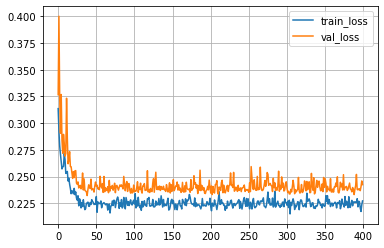

In [27]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing loss
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

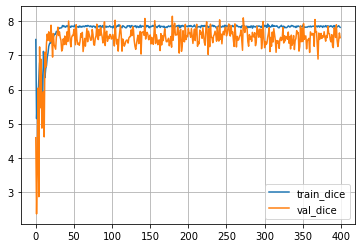

In [28]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing dice
    plt.plot(hist['dice'], label='train_dice')
    plt.plot(hist['val_dice'], label='val_dice')
    plt.legend()
    plt.grid()
    plt.show()

In [41]:
if not SEARCH_BS and not SEARCH_LR:
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[2]
    one_sample_mask = sample_val_mask[2]

In [42]:
if not SEARCH_BS and not SEARCH_LR:
    def check_model(model, img, mask, type=''):
        mask = torch.argmax(mask, axis=0).cpu().numpy()
        model.eval()
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            pred_mask = model(img)
            pred_mask = torch.argmax(pred_mask, axis=1)
            pred_mask = pred_mask.squeeze(0).type(torch.float32).detach().cpu().numpy()
            
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
        print(img.max().item(), img.min().item())
        img = (img-img.min())/(img.max()-img.min())
        img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        ax1.imshow(img)
        ax1.set_title('Image')
        ax2.imshow(mask)
        ax2.set_title('mask')
        ax3.imshow(pred_mask)
        ax3.set_title(f'pred_mask {type}')
        plt.show()

2.6399998664855957 -1.9637811183929443


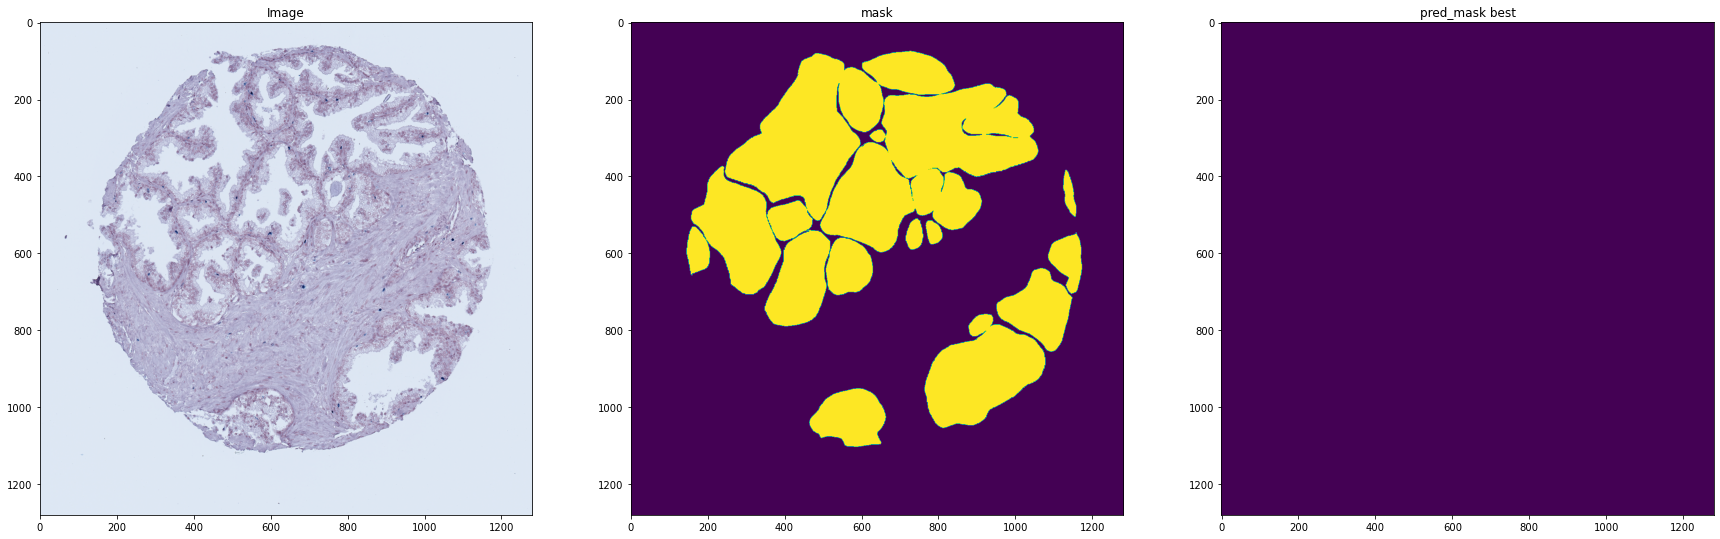

In [43]:
# Best model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_best_model)
    check_model(model, one_sample_img, one_sample_mask, type='best')

2.6399998664855957 -1.9637811183929443


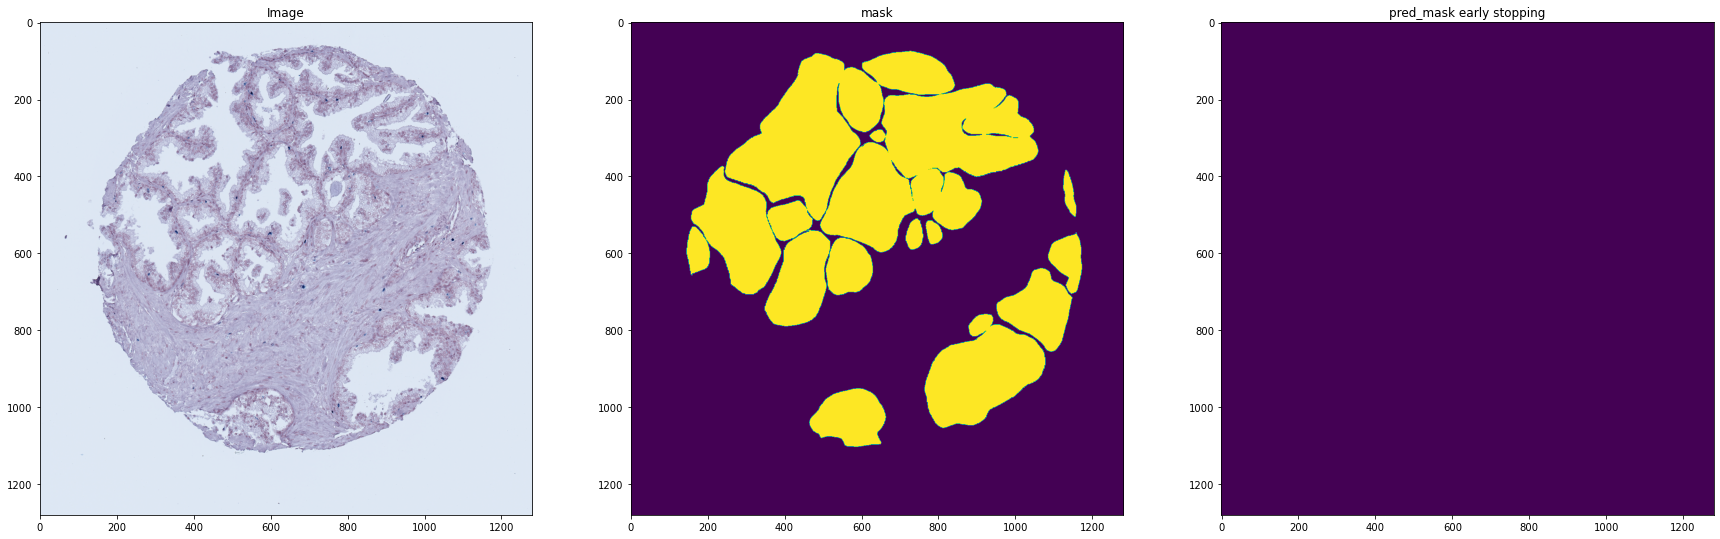

In [44]:
# Early stopping model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_early_stopping_model)
    check_model(model, one_sample_img, one_sample_mask, type='early stopping')

2.6399998664855957 -1.9637811183929443


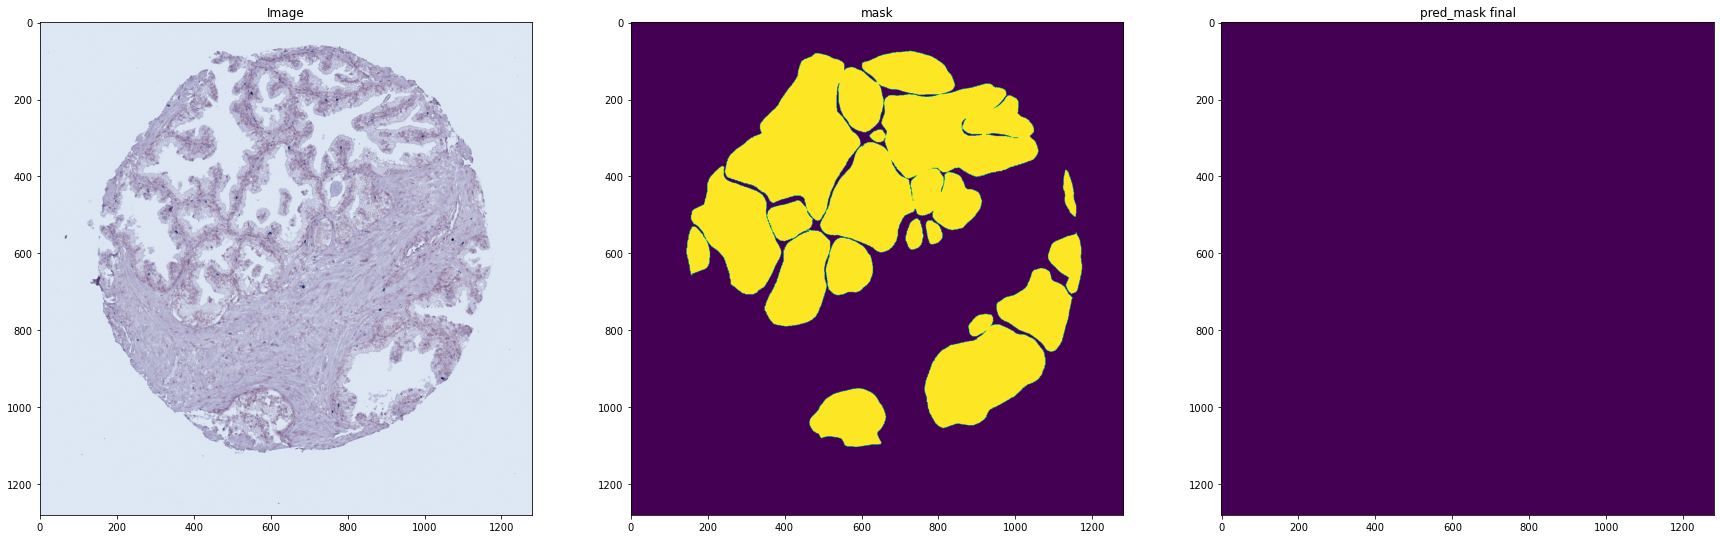

In [45]:
# Final stopping model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_final_model)
    check_model(model, one_sample_img, one_sample_mask, type='final')